# Kanapy

## Example:
Analyse grain geometries of polycrystals, extract statistical information
form 2D slices, comaparable to experiment, fit ellipsoids to 3D grains
(polyhedra) and exctract statistical information

Author: Alexander Hartmaier, ICAMS / Ruhr-University Bochum, Germany<br/>
August 2022

## Generate voxelized RVE

Generating particle distribution based on user defined statistics


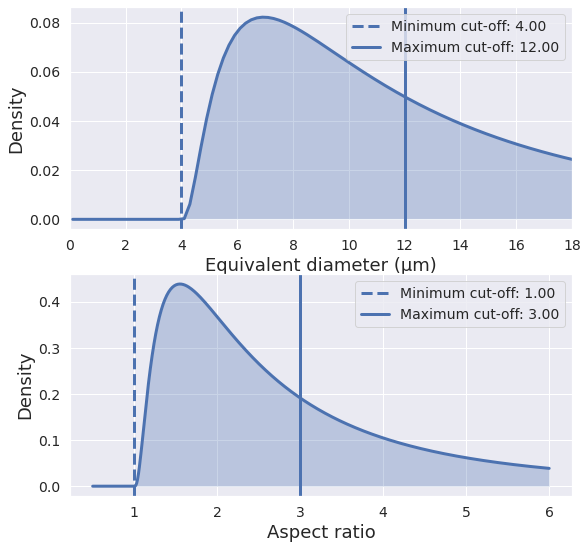

Creating an RVE based on user defined statistics
    Total number of grains        = 62
    RVE side lengths (X, Y, Z)    = 30, 30, 30
    Number of voxels (X, Y, Z)    = 20, 20, 20
    Voxel resolution (X, Y, Z)    = 1.5000, 1.5000, 1.5000
    Total number of voxels (C3D8) = 8000

Starting particle simulation
    Creating simulation box of required dimensions
    Creating particles from distribution statistics
    Particle packing by growth simulation


100%|██████████| 1001/1001 [06:00<00:00,  2.78it/s]


Completed particle packing
392 overlapping particles detected after packing
Kinetic energy of particles after packing: 10.270755318811027
Initial kinetic energy: 10.270755318811027



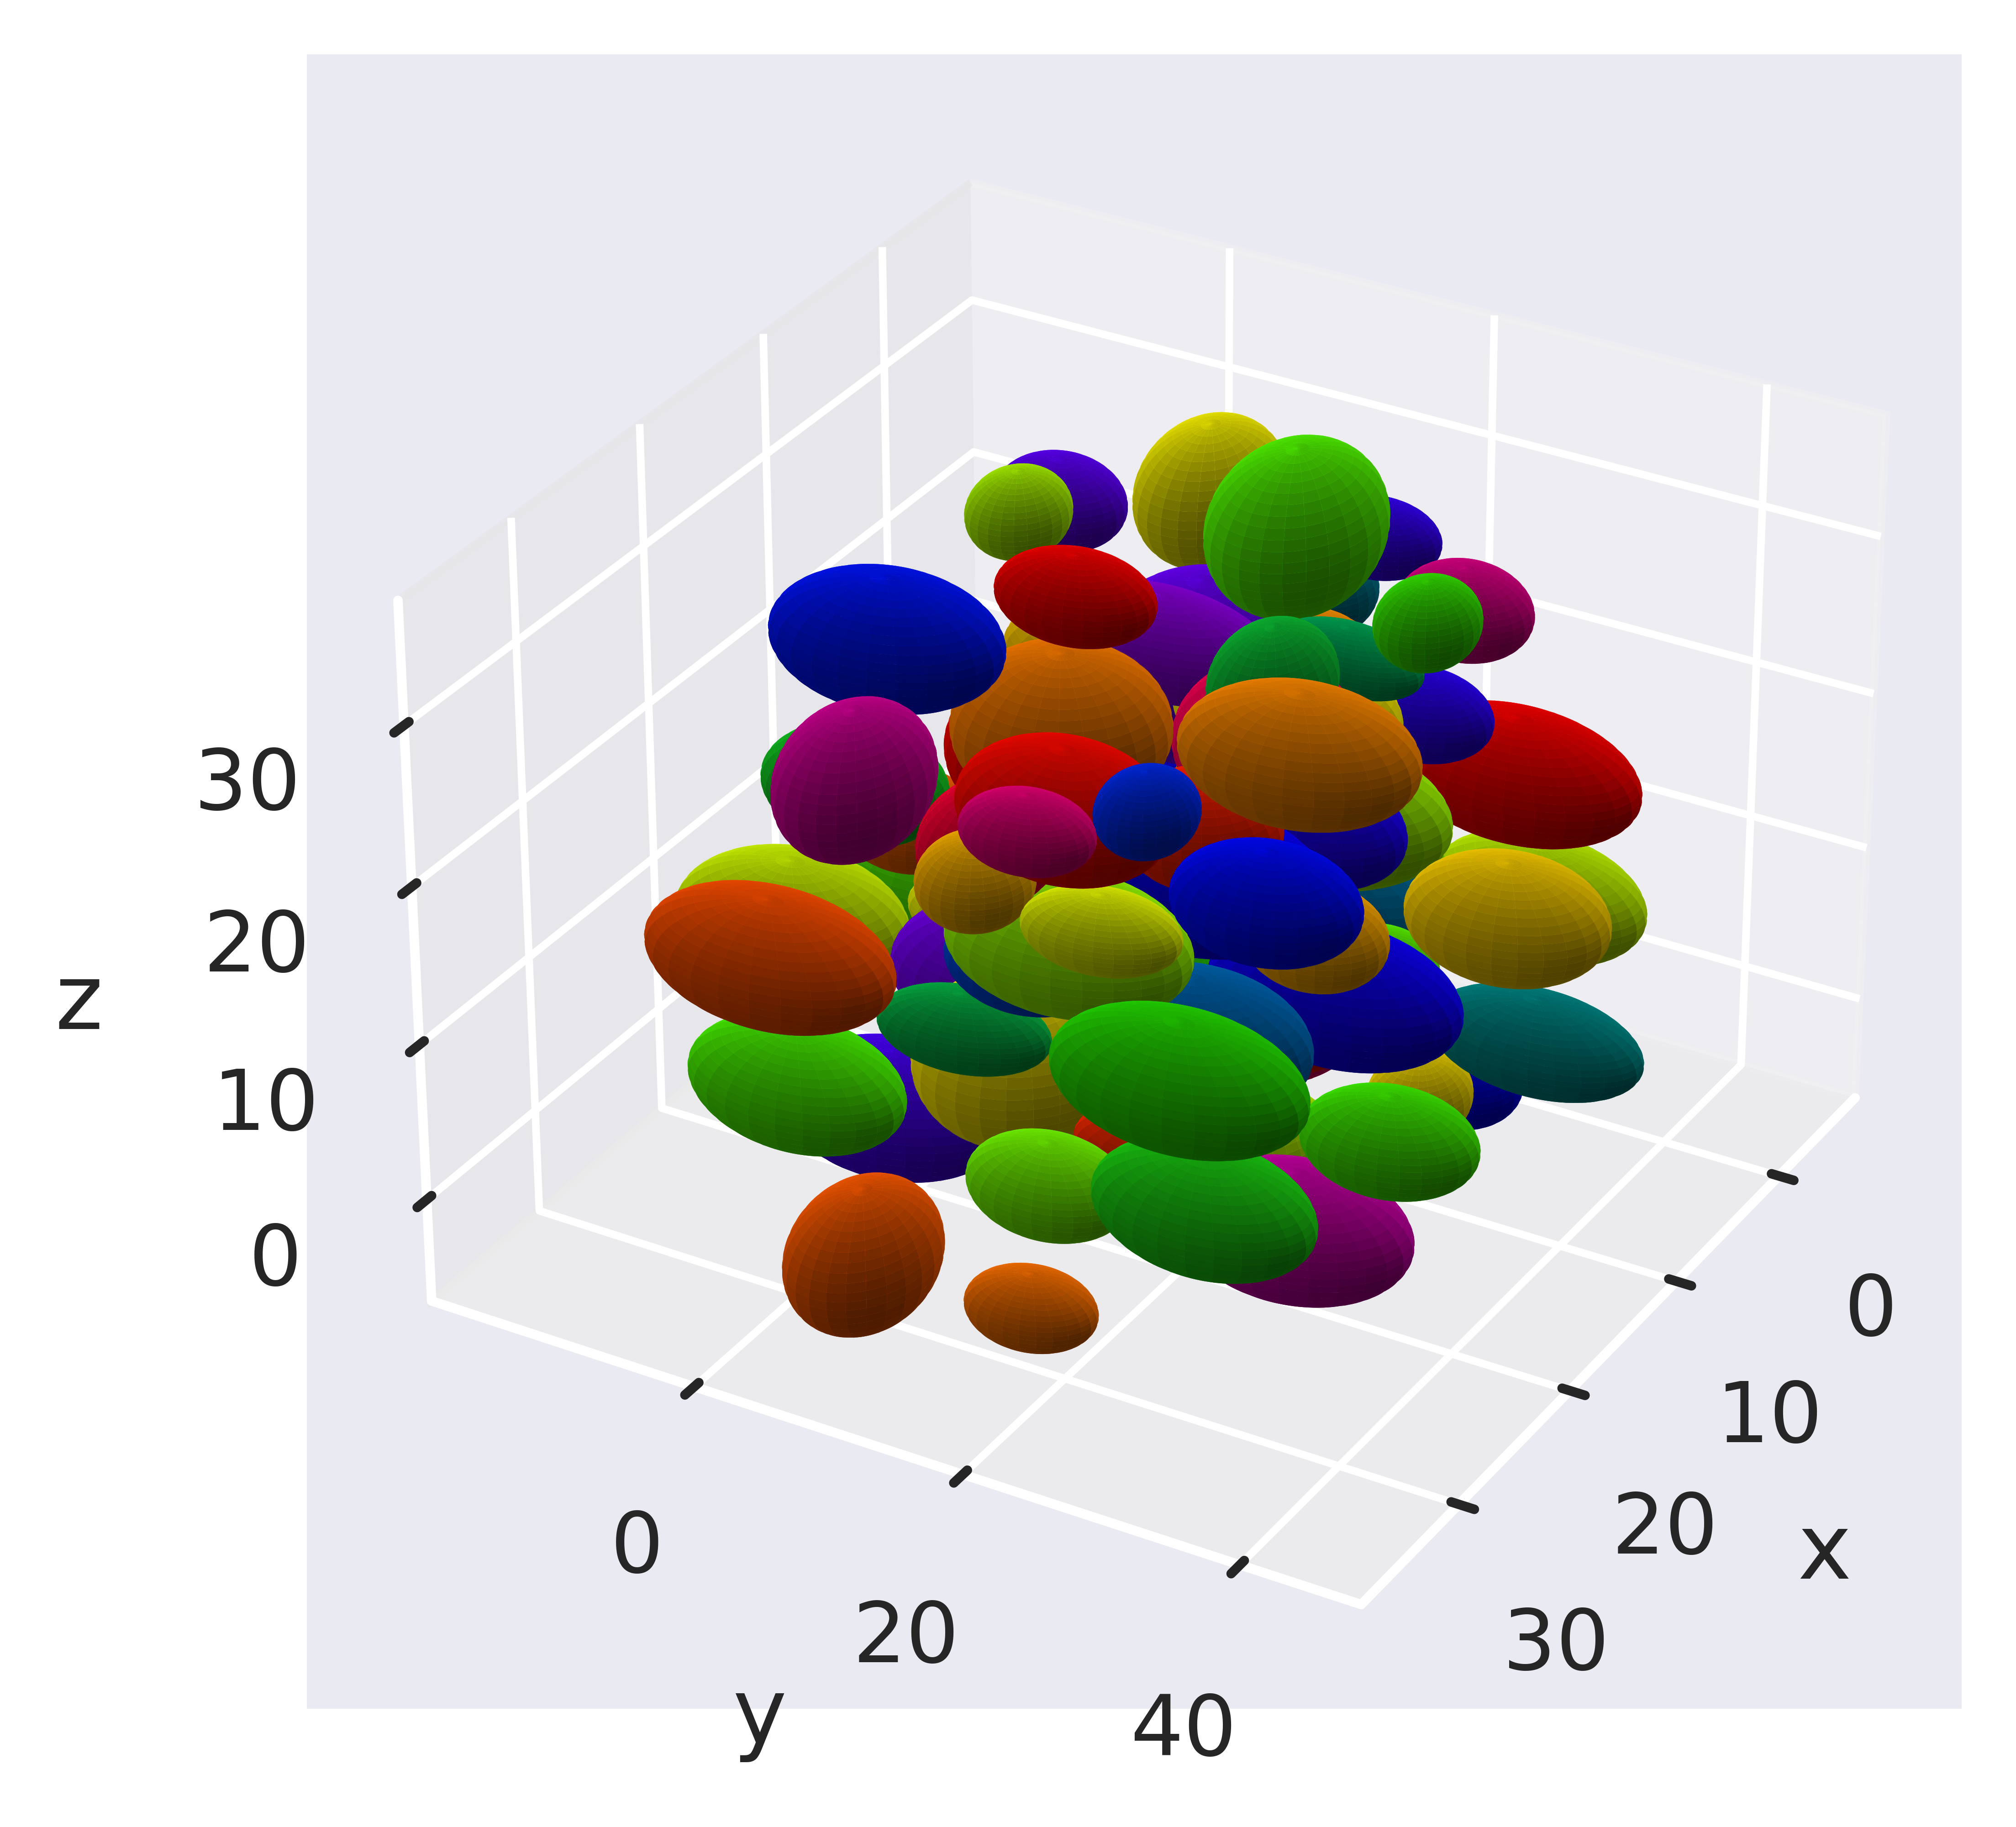


Starting RVE voxelization
    Generating voxels inside RVE
### create voxels 9261 (9261, 3)
    Assigning voxels to grains


100%|██████████| 8000/8000 [00:00<00:00, 5890876.40it/s] 


Completed RVE voxelization


Computing the L1-error between input and output diameter distributions
    L1 error between particle and grain geometries: 1.0


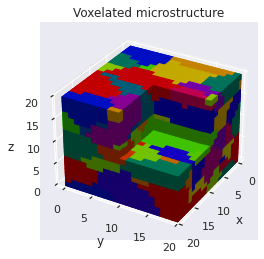

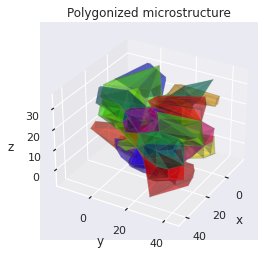

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import kanapy as knpy

texture = 'random' # Implemented textures are goss, copper, random
matname = 'Simulanium fcc'
matnumber = 4  # UMAT number for fcc Iron
Nv = 30
size = 40
periodic = True
ms_elong = {'Grain type': 'Elongated',
          'Equivalent diameter': {'std': 1.0, 'mean': 10.0, 'offs': 5.0, 'cutoff_min': 7.5, 'cutoff_max': 15.0},
          'Aspect ratio': {'std':1.0, 'mean': 1.5, 'offs': 1.0, 'cutoff_min': 1.0, 'cutoff_max': 3.0},
          'Tilt angle': {'std': 2., 'mean': 90., "cutoff_min": 0.0, "cutoff_max": 180.0},
          'RVE': {'sideX': size, 'sideY':size, 'sideZ': size, 'Nx': Nv, 'Ny': Nv, 'Nz': Nv},
          'Simulation': {'periodicity': str(periodic), 'output_units': 'mm'},
          'Phase': {'Name': matname, 'Number': matnumber, 'Volume fraction': 1.0}}

ms_elong = [ms_elong]

ms = knpy.Microstructure(ms_elong)
ms.init_stats()
ms.init_RVE()
ms.pack()
ms.plot_ellipsoids()
ms.voxelize()
ms.plot_voxels()
ms.analyze_RVE()
ms.plot_polygons()

In [ ]:
ms.plot_slice(cut='xy', pos='top', data='poly')
ms.plot_slice(cut='xz', pos='top', data='poly')
ms.plot_slice(cut='yz', pos='top', data='poly')

## Generate orientation for specified texture

In [5]:
# Test cases for misorientation distribution (MDF)
"""adapted from
Miodownik, M., et al. "On boundary misorientation distribution functions
and how to incorporate them into three-dimensional models of microstructural
evolution." Acta materialia 47.9 (1999): 2661-2668.
https://doi.org/10.1016/S1359-6454(99)00137-8
"""
if knpy.MTEX_AVAIL:
    mdf_freq = {
      "High": [0.0013303016, 0.208758929, 0.3783092708, 0.7575794912, 1.6903069613,
               2.5798481069, 5.0380640643, 10.4289690569, 21.892113657, 21.0,
               22.1246762077, 13.9000439533],
      "Low":  [4.5317, 18.6383, 25, 20.755, 12.5984, 7.2646, 4.2648, 3.0372, 2.5,
               1, 0.31, 0.1],
      "Random": [0.1, 0.67, 1.9, 3.65, 5.8, 8.8, 11.5, 15.5, 20, 16.7, 11.18, 4.2]
    }
    mdf_bins = np.linspace(62.8/12,62.8,12)

    # generate grain orientations and write ang file
    """
    Different textures can be choosen and assinged to the RVE geometry that has
    been defined above.
    Texture is defined by the orientation of the ideal component in Euler space
    ang and a kernel halfwidth omega. Kernel used here is deLaValleePoussin.
    The function createOriset will first create an artificial EBSD by sampling
    a large number of discrete orientations from the ODF defined by ang and
    omega. Then a reduction method is applied to reconstruct this initial ODF
    with a smaller number of discrete orientations Ngr. The reduced set of
    orientations is returned by the function.
    For more information on the method see:
    https://doi.org/10.1107/S1600576719017138
    """
    if texture == 'goss':
        ang = [0, 45, 0]    # Euler angle for Goss texture
        omega = 7.5         # kernel half-width
    elif texture == 'copper':
        ang = [90, 35, 45]
        omega = 7.5
    elif texture == 'random':
        #For Random texture, no subsampling and ODF recreation is neccessary
        ori_rve = knpy.createOrisetRandom(ms.Ngr)
    else:
        raise ValueError('texture not defined. Take goss, copper or random')
    if texture != 'random':
        ori_rve = knpy.createOriset(ms.Ngr, ang, omega, hist=mdf_freq['Low'],
                                    shared_area=ms.shared_area)

    # write Euler angles of grains into Abaqus input file
    knpy.writeAbaqusMat(matnumber, ori_rve)
    !mv Material.inp 'mat{matnumber}_gr{ms.Ngr}_tx-{texture[0:4]}.inp'

    # write Abaqus input file for voxelated structure
    ms.output_abq('v', name=f'geom{Nv}_gr{ms.Ngr}_tx-{texture[0:4]}.inp')

initialize MTEX 5.5.2  ....Warning: "/opt/netapps/anaconda/addons/kanapy/libs/mtex/extern/nfft_openMP" not found in path.
> In rmpath (line 71)
In check_installation (line 7)
In startup_mtex (line 79)
In startup (line 9)

********************************************************************************
 
  MTEX: Error running NFFT!
   
  The original error message was:
  Undefined function 'nfsftmex' for input arguments of type 'char'.
 
 I did not get NFFT working. This restricts the functionality of MTEX.
 To overcome this restriction you may need to compile the NFFT your own.
 Please have a look at https://github.com/mtex-toolbox/mtex/blob/develop/extern/nfft_openMP/readme.md

********************************************************************************
 done!
 
 For compatibility reasons MTEX is not using OpenMP.
 You may want to switch on OpenMP in the file <a href="matlab: edit mtex_settings">mtex_settings.m</a>
 

Writing ABAQUS (.inp) file---->DONE!

